## Overview

Perform some analysis of IBD, specifically:

- Plot summaries of IBD data (total IBD, no. tracts), comparing within and between sampling sites.

- Perhaps a network?

In [1]:
%run setup.ipynb

In [2]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

In [3]:
regions = {
    "3R": (1000000, 37000000),
    "3L": (15000000, 41000000)}

In [4]:
from pathlib import Path

In [5]:
ibd_data = Path("/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2", "output")

In [6]:
colnames = ("sample1", "id1", "sample2", "id2", 
            "chrom", "start", "stop", "LOD")

In [7]:
def get_ibd_calls(pop, min_len=10000):

    q = {}
    for chrom, reg in regions.items():
        fstem = ibd_data / chrom / (pop + ".ibd")
        start, end = reg
        q[chrom] = pd.read_csv(
            fstem, header=None, names=colnames, sep="\t").query(
            "start >= @start").query(
            "stop < @end")

    ibd_tab = pd.concat(q).reset_index(drop=True)
    ibd_tab["ibd_chunk_size"] = ibd_tab.stop - ibd_tab.start
    ibd_tab = ibd_tab.query("ibd_chunk_size >= @min_len")
    return ibd_tab

## Distribution of IBD chunk sizes

Consider applying minimum? Drop below 10k? 

In [8]:
from itertools import combinations
from scipy.stats import mannwhitneyu

In [16]:
def within_between(pair, df, loc='region'):
    
    return "-".join(sorted(df.loc[list(pair)][loc].unique()))

In [38]:
def stat_tests(all_ibd):
    
    rholder = []
    result = r"{a} vs {b}. U={stat}. P-value={pv:.2e}"

    for (a, b) in combinations(all_ibd.site.unique(), 2):

        xval = all_ibd.query("site == @a").IBDsum
        yval = all_ibd.query("site == @b").IBDsum

        x = mannwhitneyu(x=xval, y=yval)

        if x.pvalue < 0.001:
            q = "$^{**}$"
        elif x.pvalue < 0.01:
            q = "$^{*}$"
        else:
            q = ""

        rholder.append(
            result.format(a=a, b=b, stat=x.statistic, pv=x.pvalue)+q)
        
    return rholder

In [45]:
def ibd_plots(all_ibd, statres, max_chunk):

    _ = sns.lmplot(
        x="IBDsum", y="IBDcount",
        data=all_ibd, 
        hue="site", 
        fit_reg=False)

    fig, ax = plt.subplots()
    ax = sns.violinplot(
        x="site", y="IBDsum", data=all_ibd)
    ax.set_ylim(bottom=0.0)

    fig, ax = plt.subplots()
    ax = sns.boxplot(x="site", y="IBDcount", 
                     data=all_ibd)
    ax.set_ylim(bottom=0.0)

    ## Alternate data presentation
    fig, ax = plt.subplots()
    ax = sns.stripplot(x="site", y="IBDsum", 
                       data=all_ibd, jitter=True,
                       alpha=0.5)

    ax.set_ylim(bottom=-1)
    ax.text(0.9, ax.get_ylim()[1]*1.1, "\n".join(statres), fontsize=6)

    
    bins = np.linspace(0, max_chunk, 50)
    fig, axes = plt.subplots(1, 6, sharex=True, sharey=True,
                             figsize=(10, 4))

    for v, ax in zip(all_ibd.site.unique(), axes):
        
        a = all_ibd.query("site == @v").IBDsum
        
        sns.distplot(a, ax=ax, 
                     kde=False, 
                     norm_hist=True,
                     bins=bins)
        ax.set_title(v)

In [46]:
def analysis_wrapper(pop):
    
    ibd_tab = get_ibd_calls(pop)
    
    sns.distplot(ibd_tab.ibd_chunk_size)

    samples = phase2_ar1.df_samples.query("population == @pop").copy()
    
    all_samples = samples.index.tolist()
    
    t = tuple(combinations(all_samples, 2))
    
    all_pairs_ibd = pd.DataFrame(
        index=pd.MultiIndex.from_tuples(t),
        columns=["IBDsum", "IBDcount", "site"], dtype=None)
    
    # group the original data to look up by pair.
    # We know that order ensures (A, B), never (B, A)
    g = ibd_tab.groupby(["sample1", "sample2"])
    
    samples['greater_region'] = samples.region.str.replace("Bana .+", "Bana")
    
    for q in t:
    
        state = within_between(q, samples, loc='greater_region')

        try:
            ibdsum, ibdc = g.get_group(q).ibd_chunk_size.aggregate(
                [np.sum, len])
        except KeyError:
            ibdsum, ibdc = 0, 0

        all_pairs_ibd.loc[q] = ibdsum, ibdc, state
    
    rholder = stat_tests(all_pairs_ibd)
    
    for f in "IBDsum", "IBDcount":
        all_pairs_ibd[f] = all_pairs_ibd[f].astype("int")
    
    ibd_plots(all_pairs_ibd, rholder, ibd_tab.ibd_chunk_size.max())

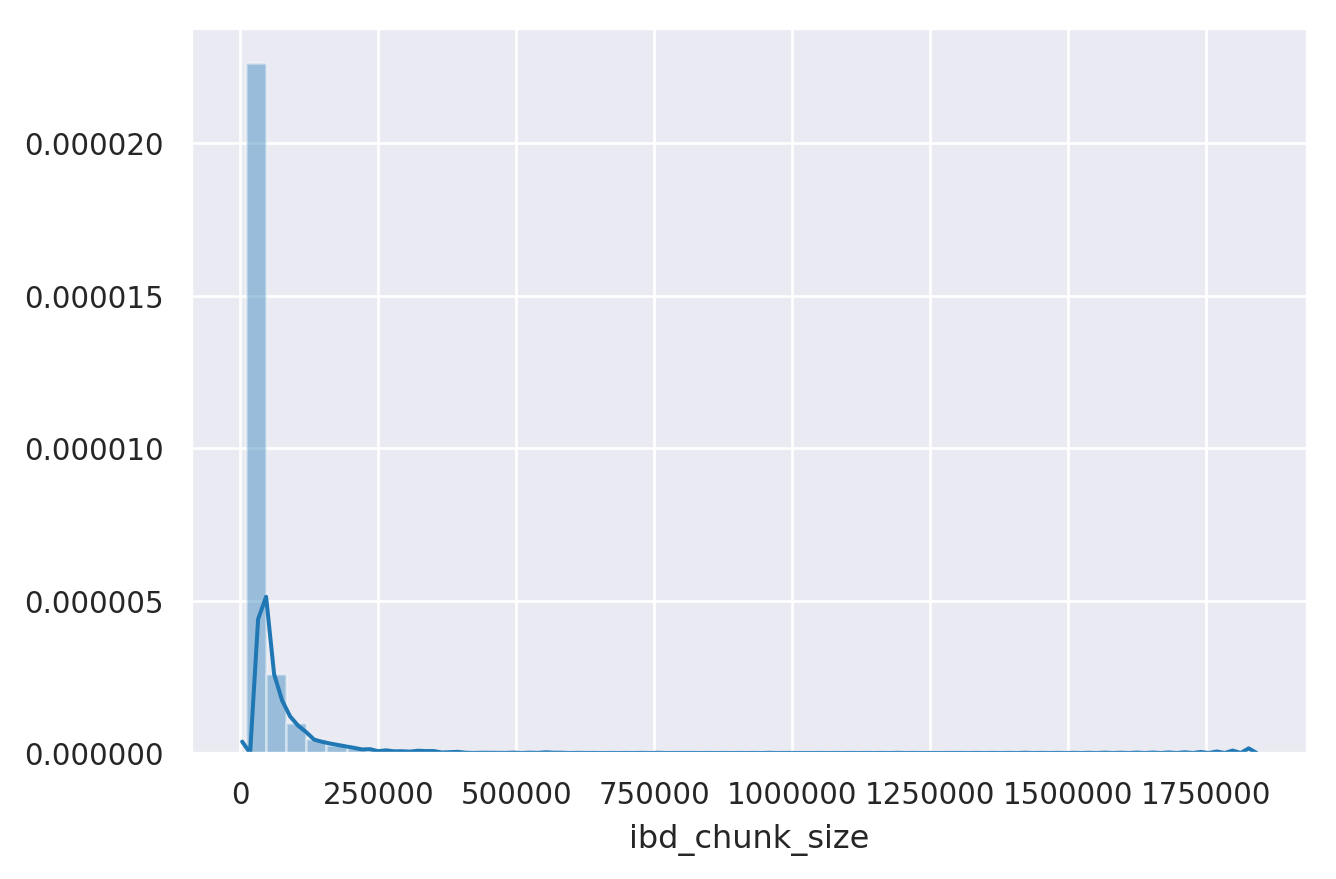

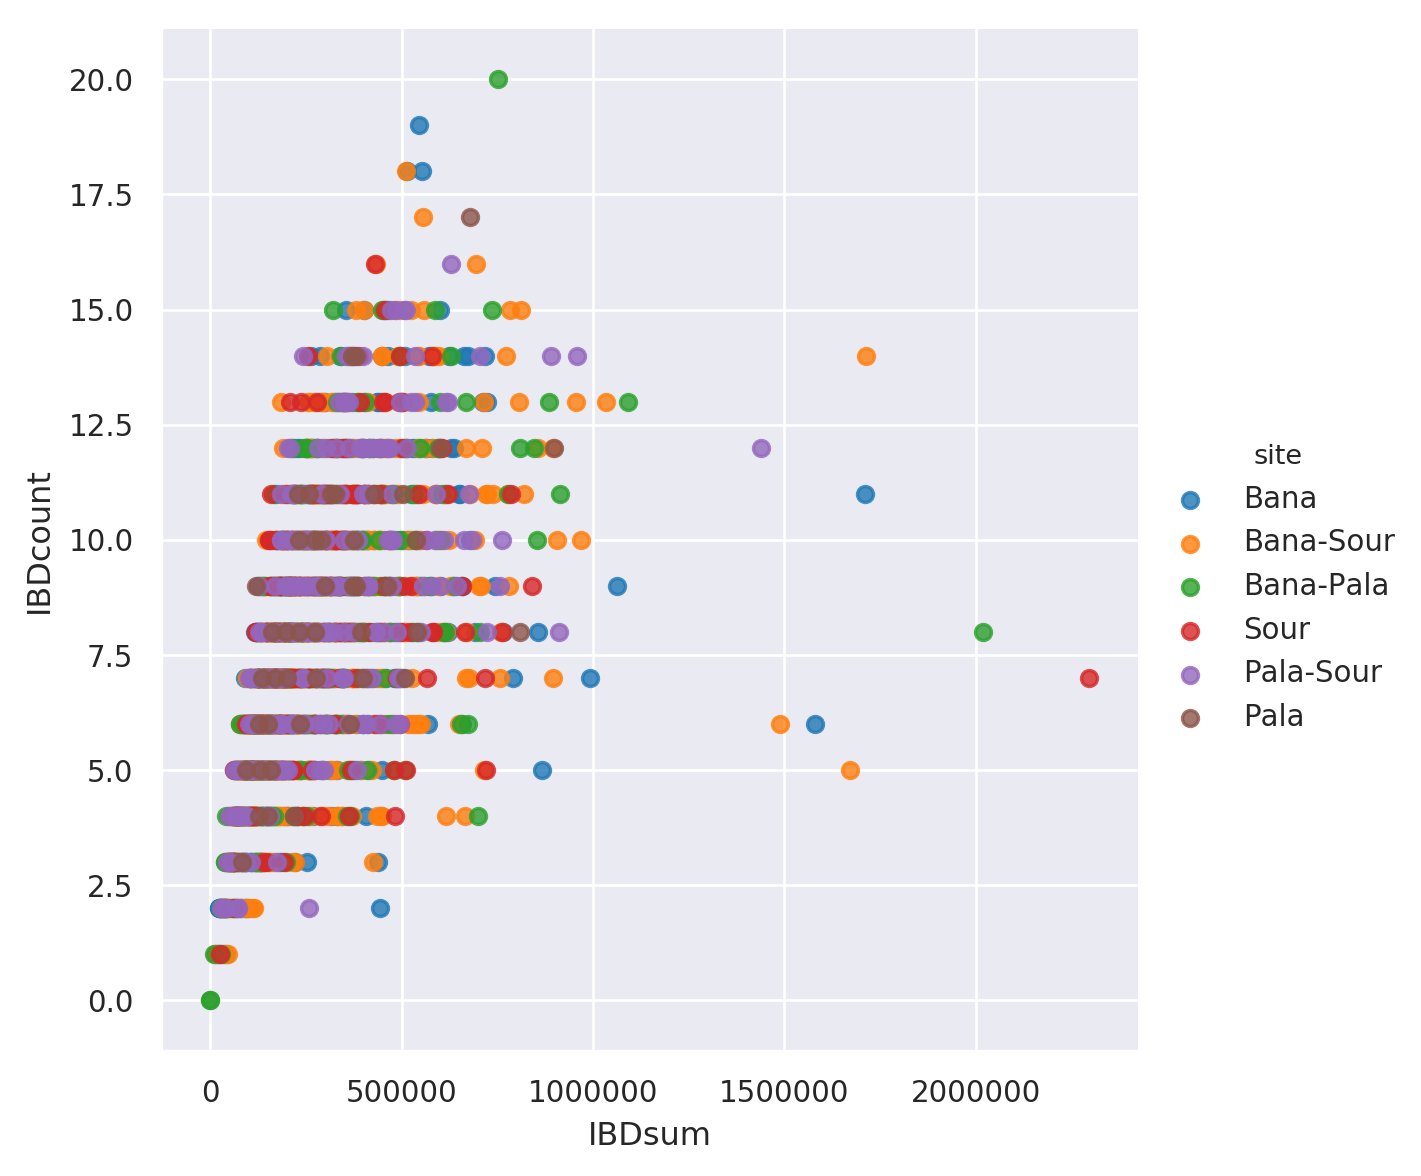

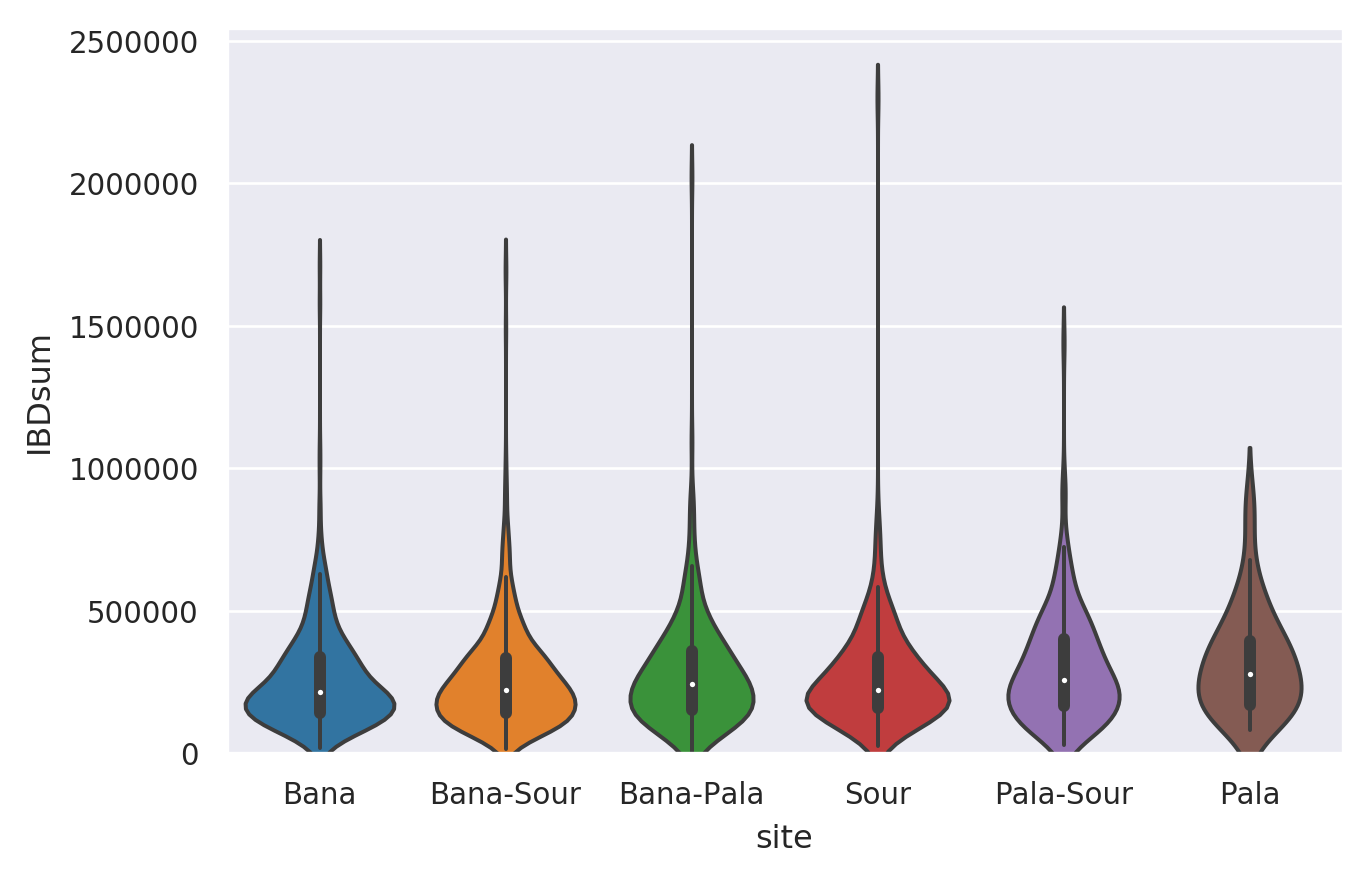

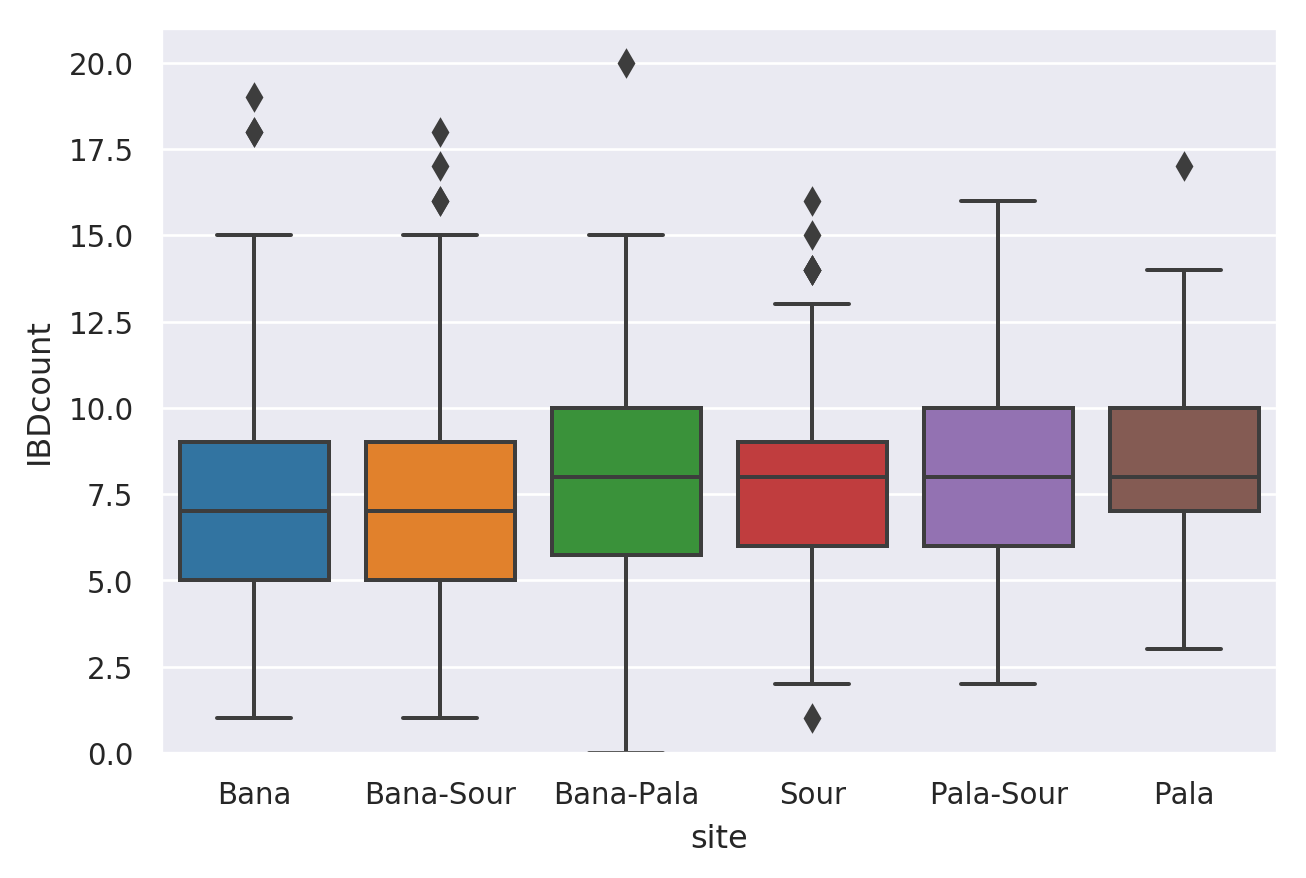

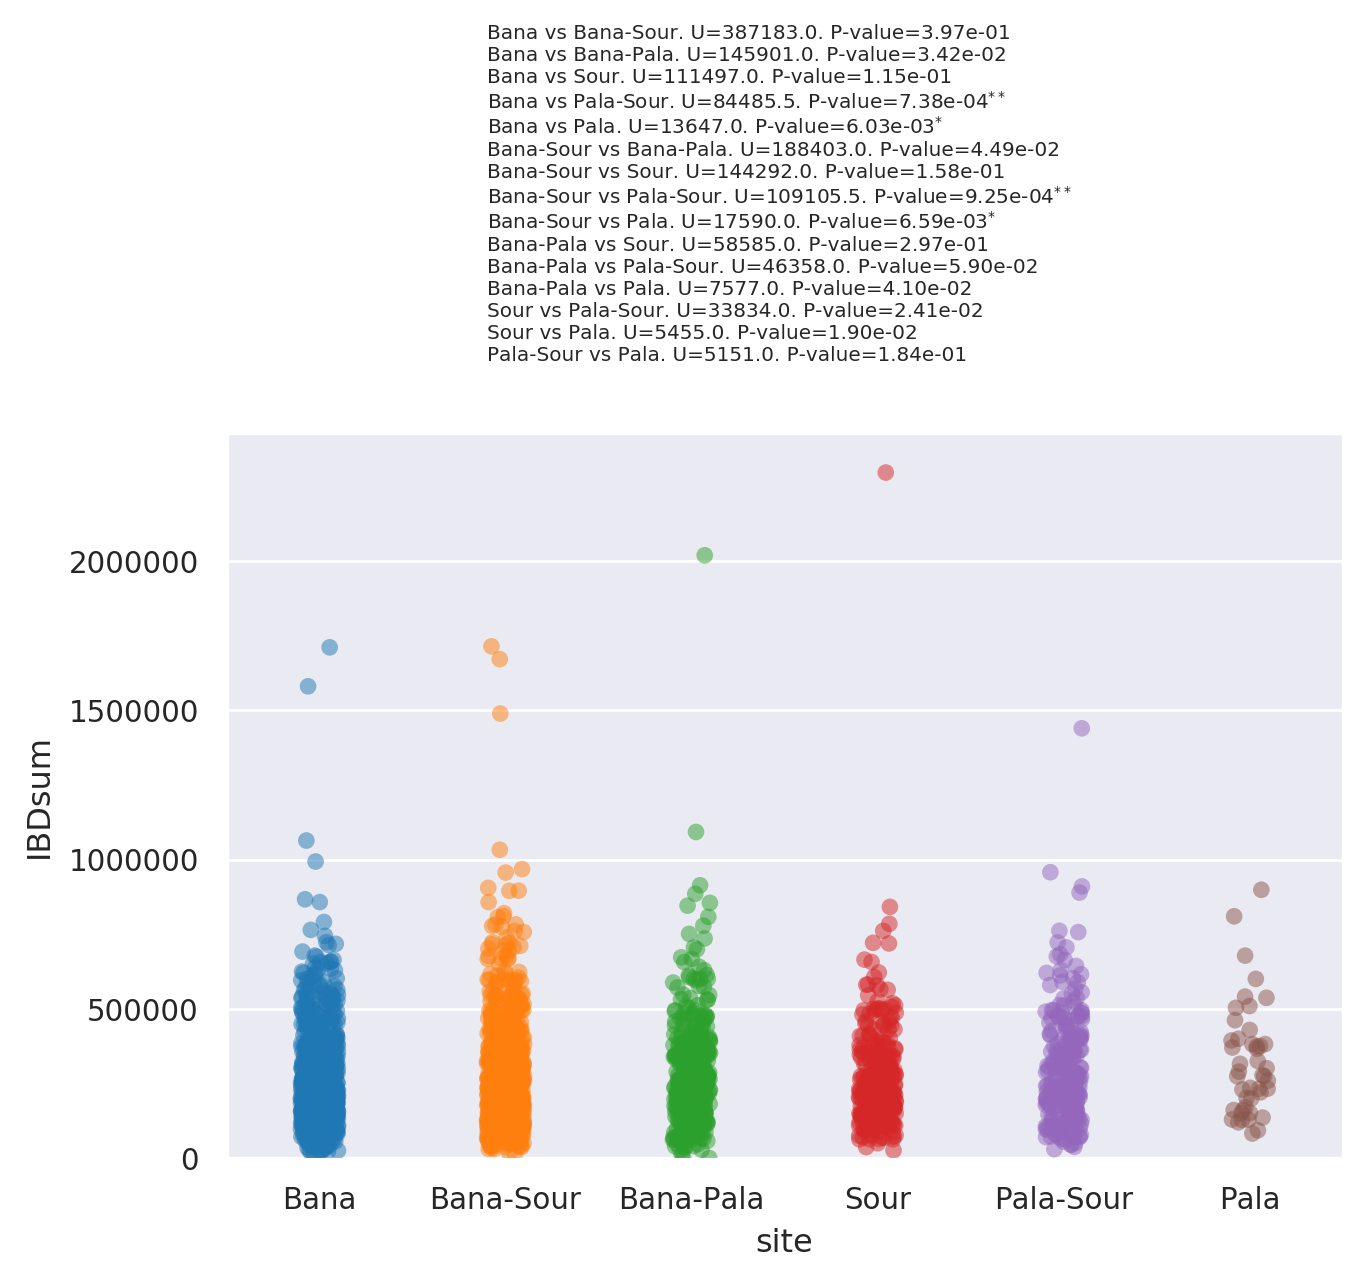

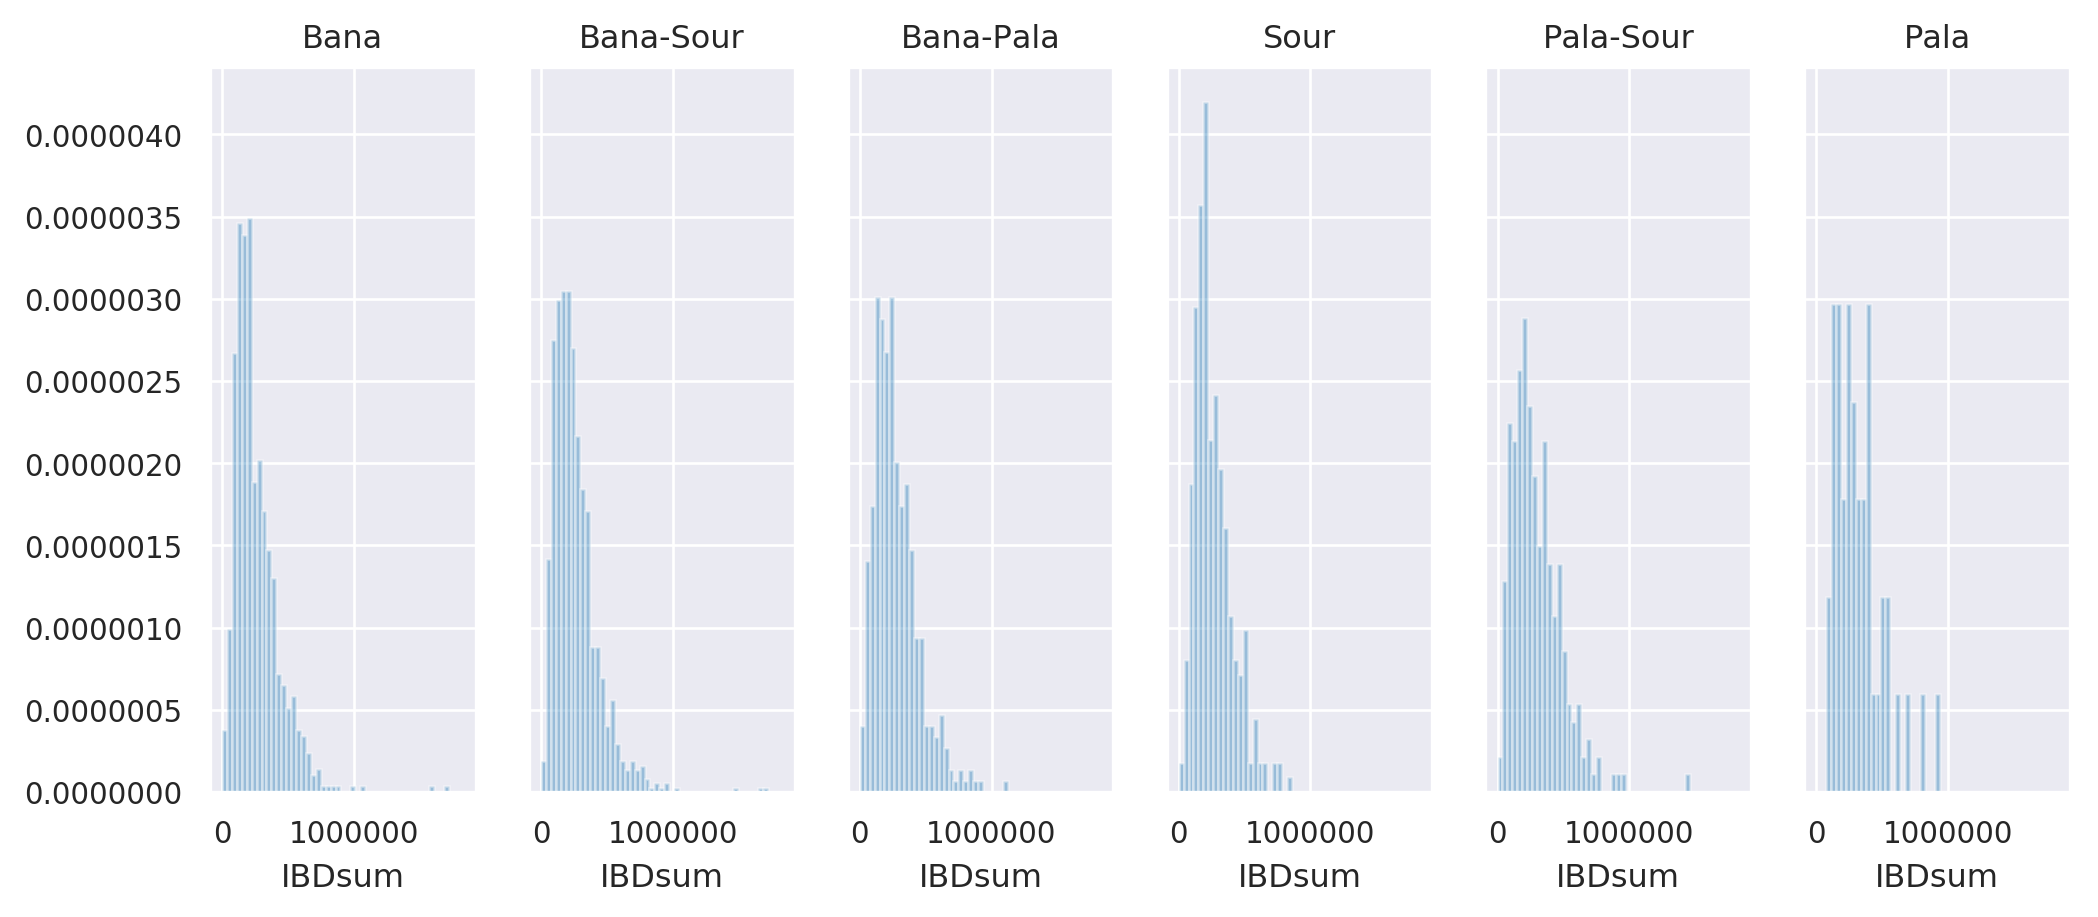

In [47]:
analysis_wrapper("BFcol")

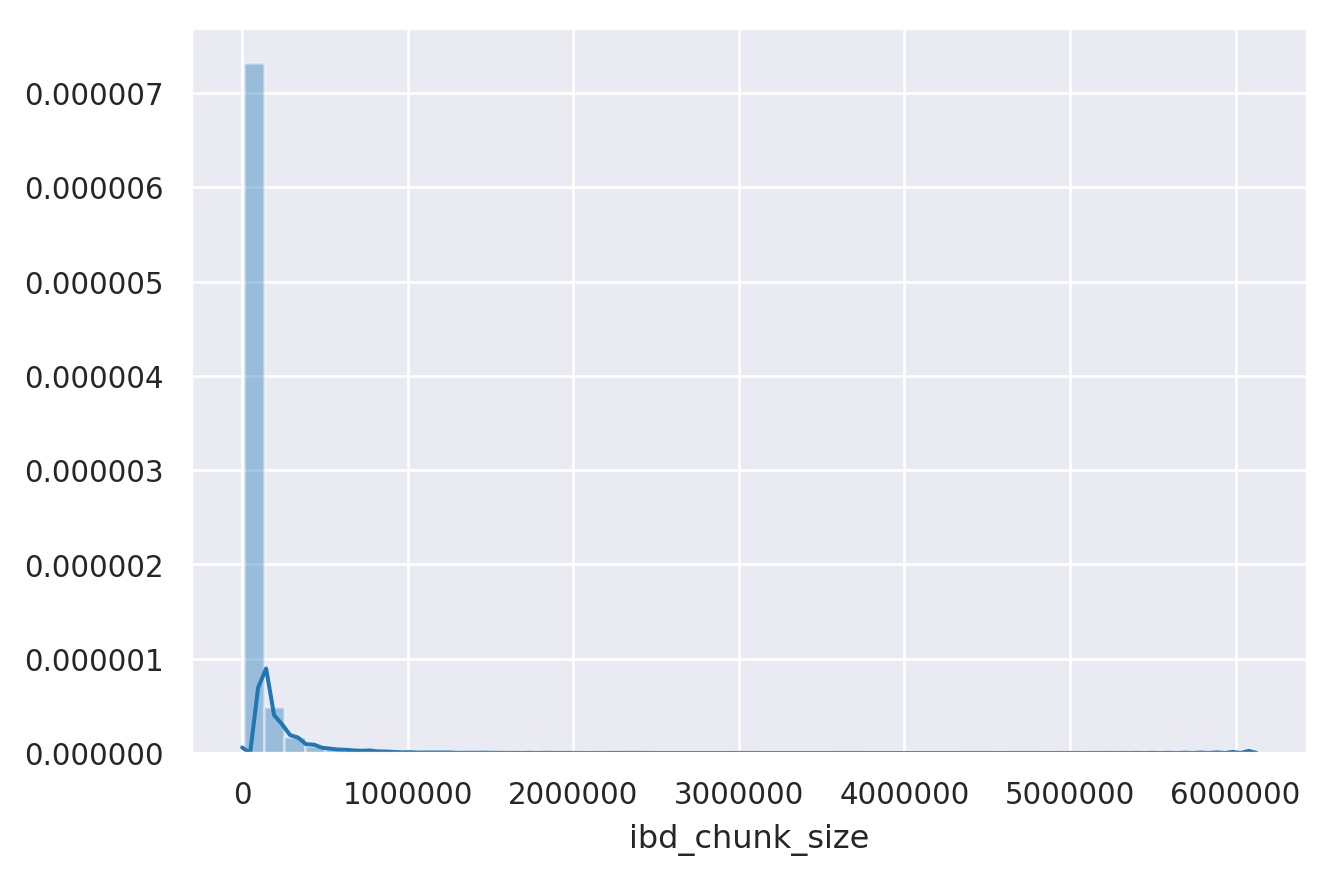

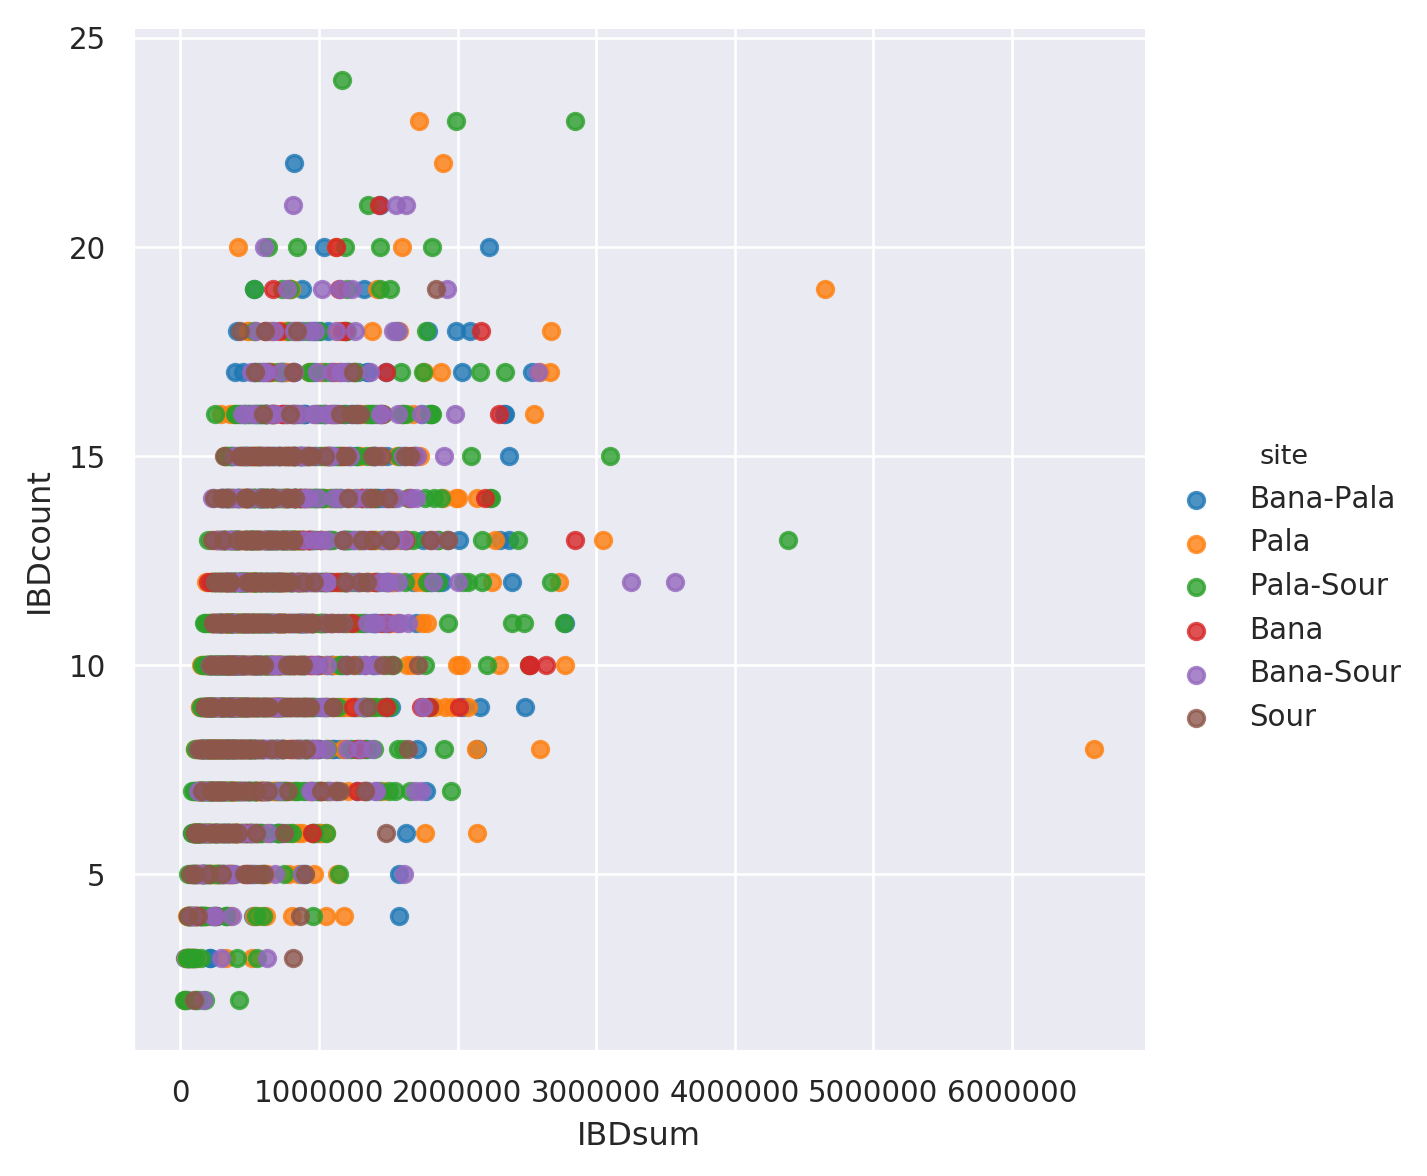

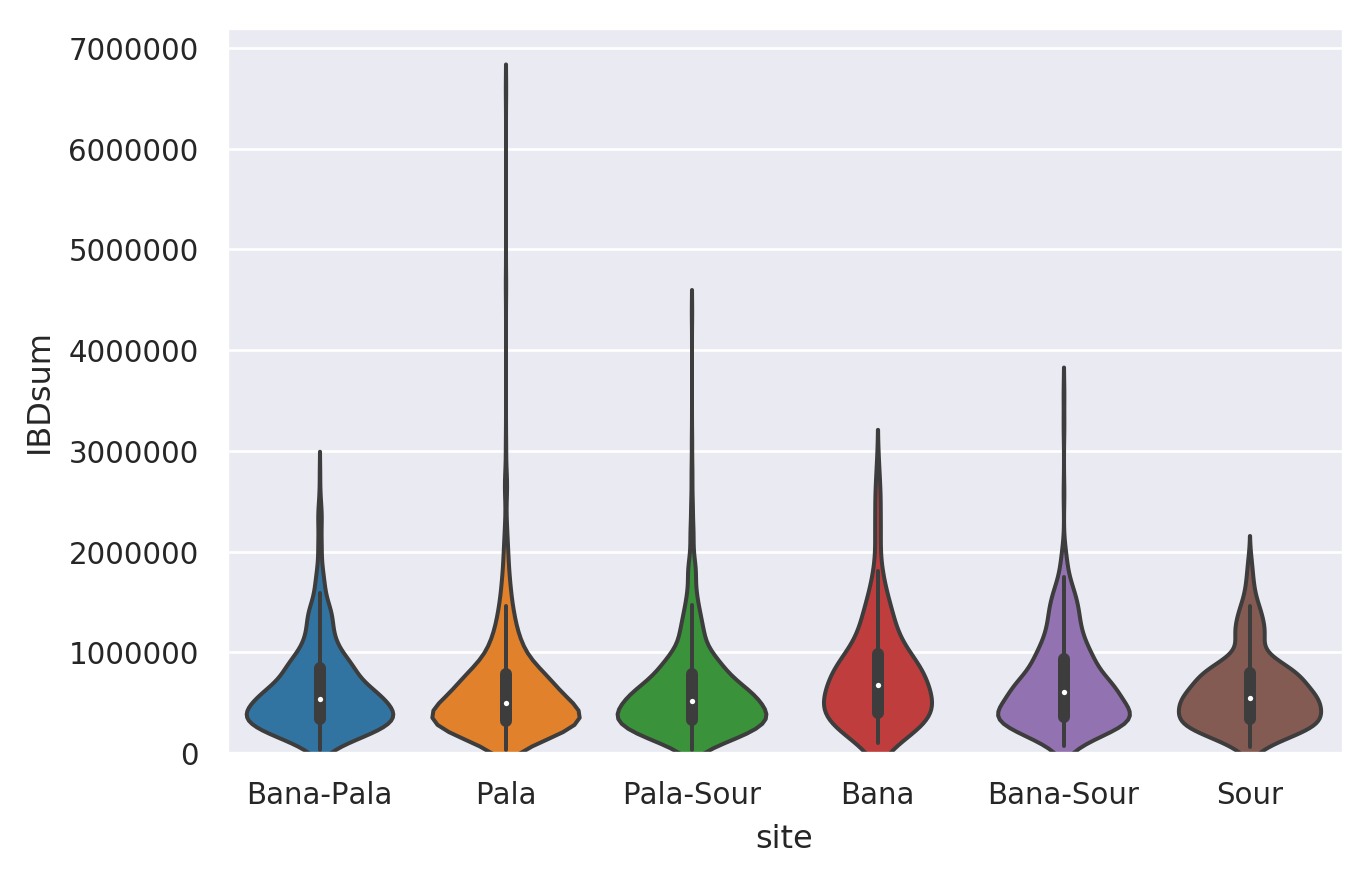

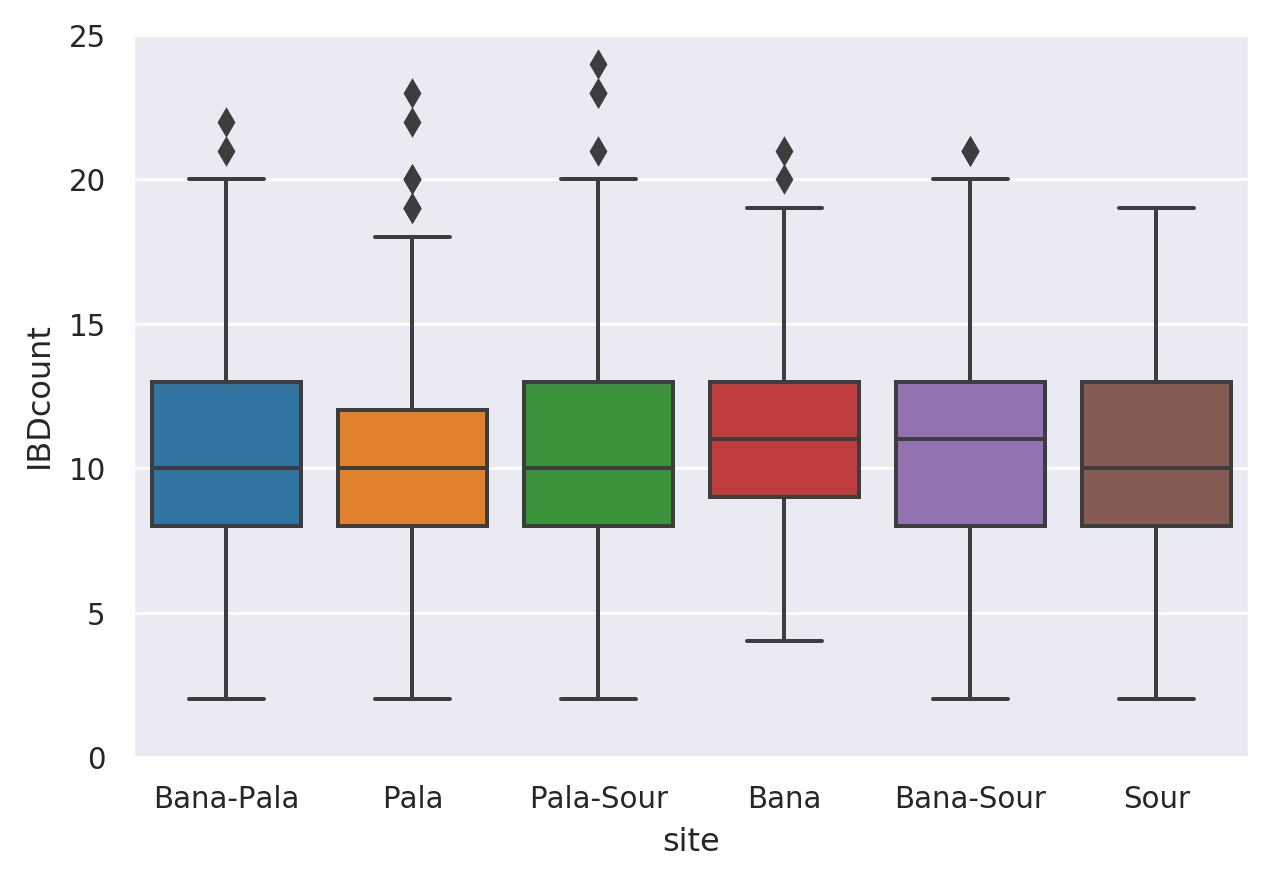

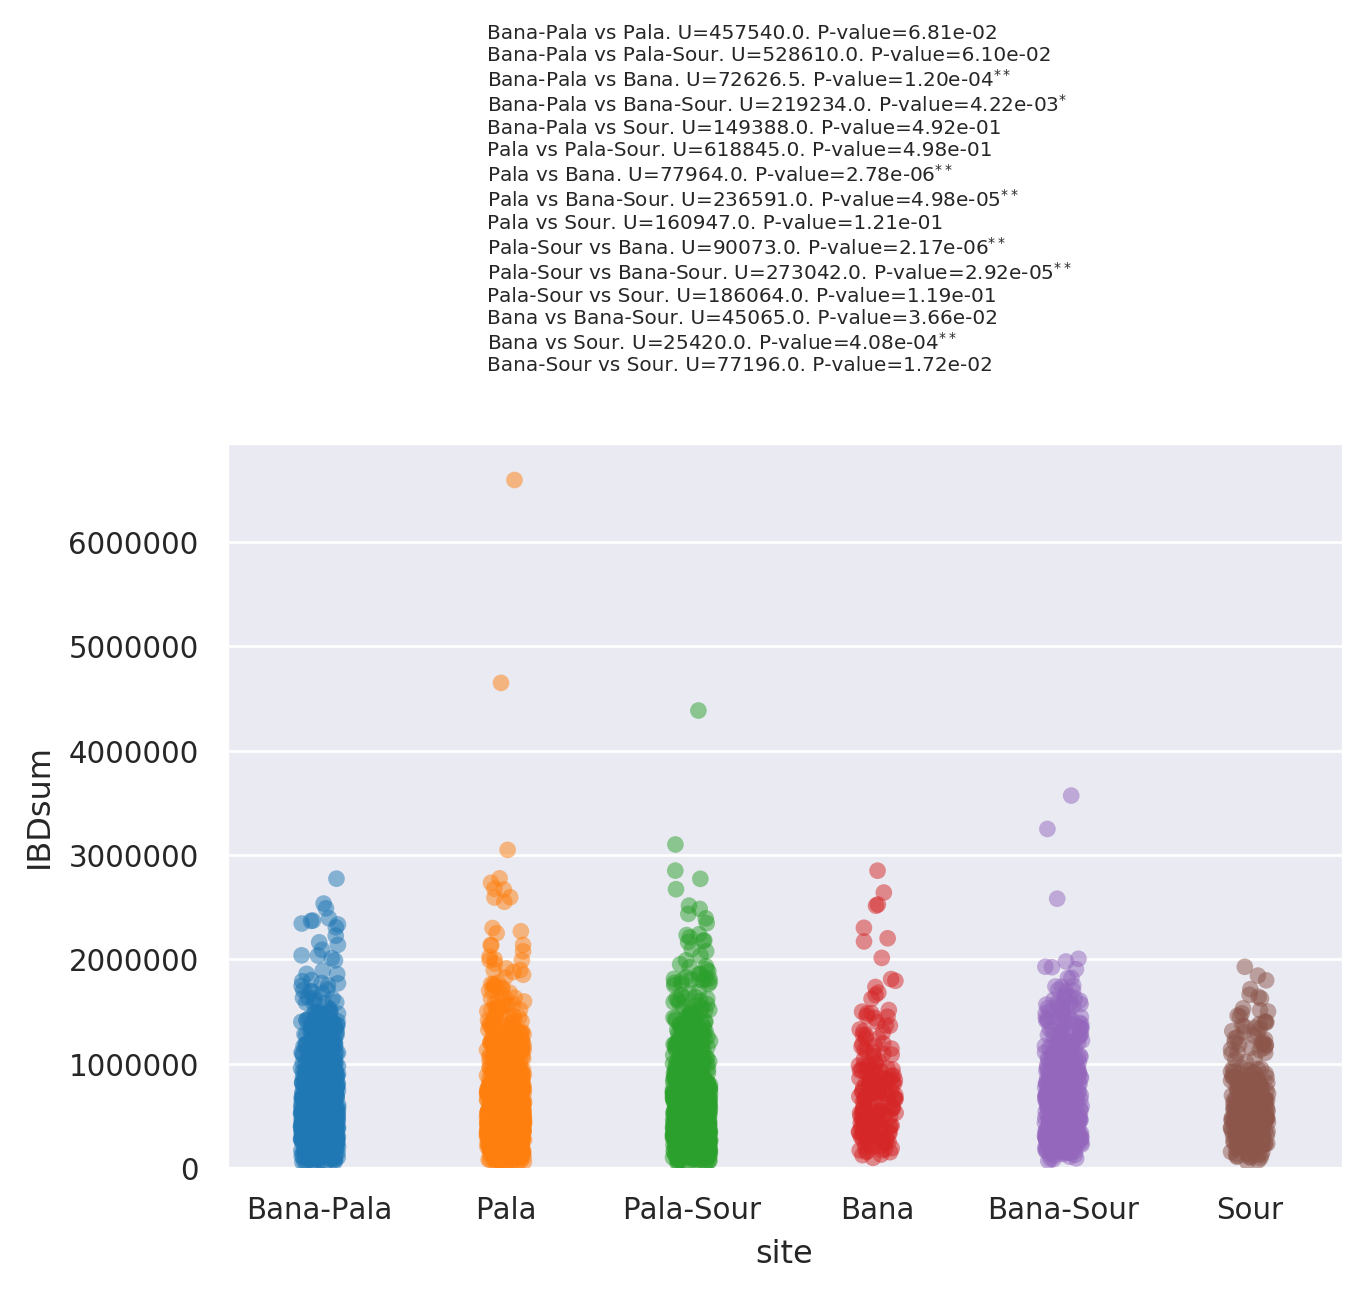

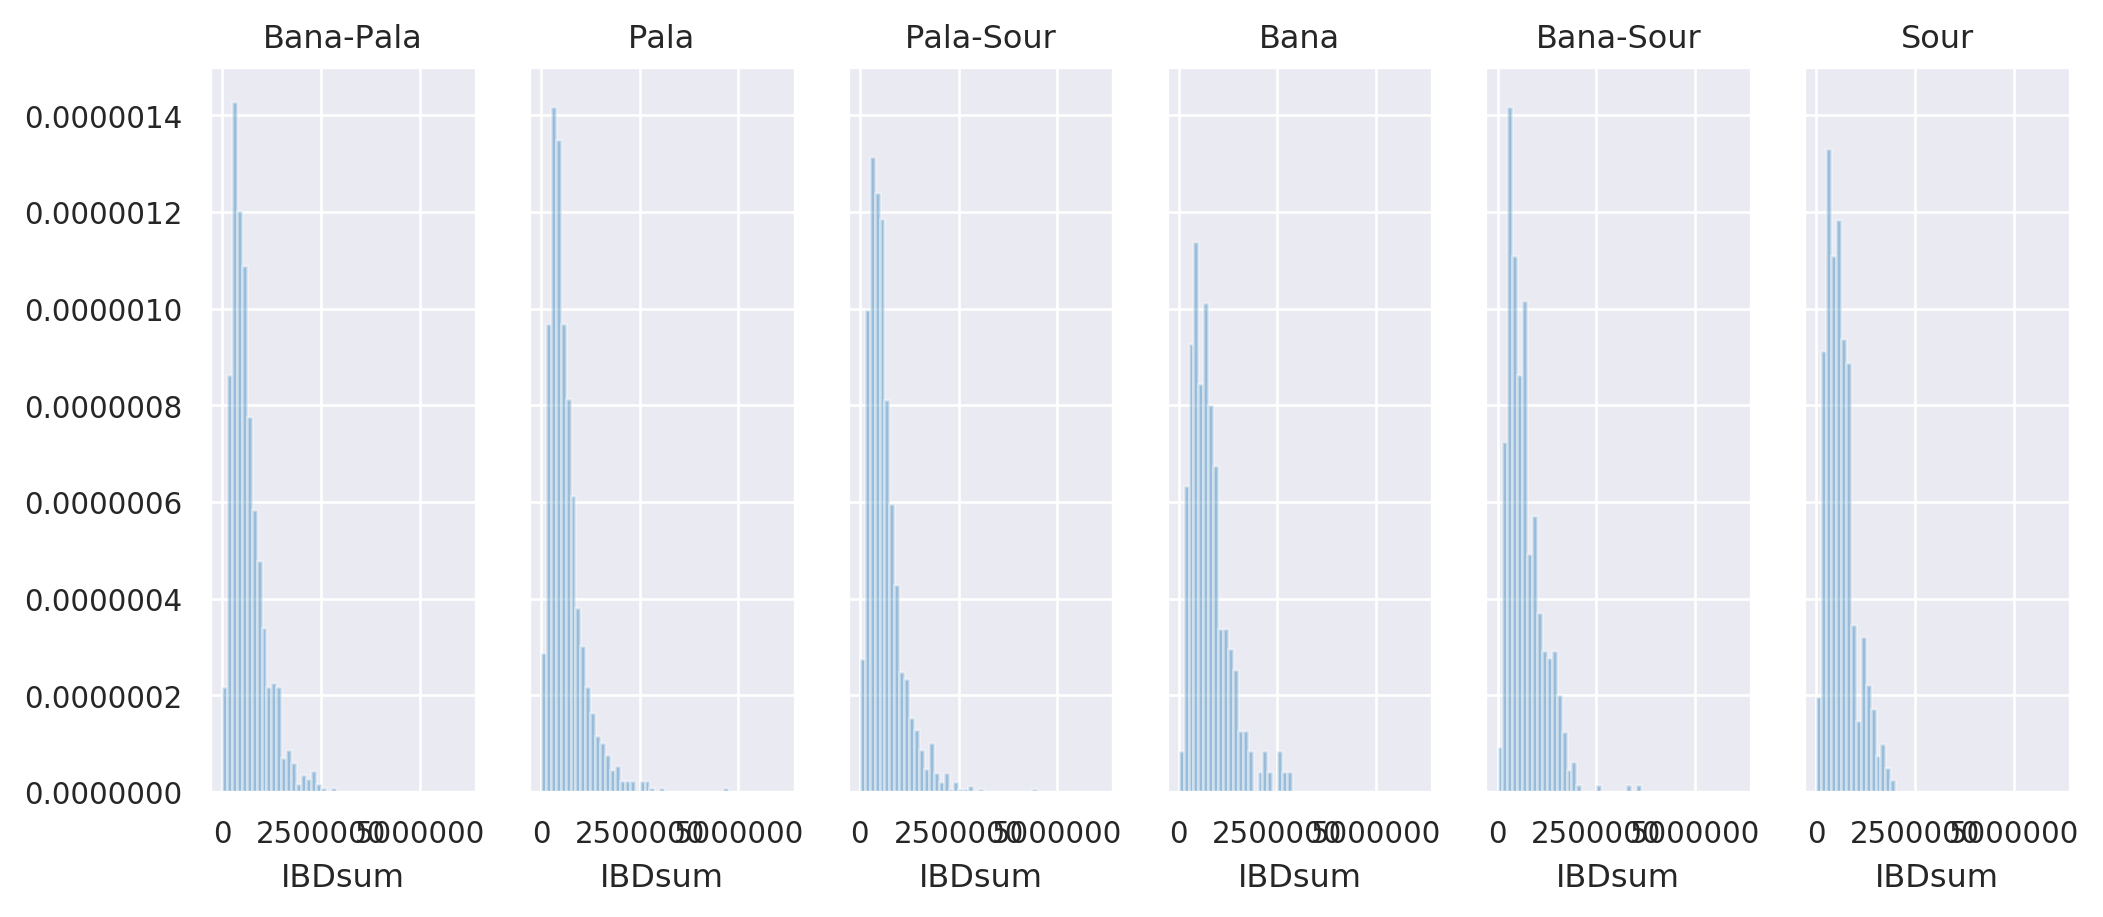

In [48]:
analysis_wrapper("BFgam")